In [1]:
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sys
sys.path.append("..")
from spatial_ultis import *

In [5]:
changed_param_exp_list = [0,-4,-8,-12,-16,-20]
changed_param_plot_list = np.linspace(0,-20,100)
fig_filename, xlabel = 'j_EI', r"$\overline{g}_{EI}$"

def generate_params(changed_param):   
    rescale = 1250
    N_E, N_I = 22500, 5625
    conn_NEE, conn_NIE, conn_NEI, conn_NII = 800, 200, 800, 200
    J_EE, J_IE, J_EI, J_II = 5/rescale, 9/rescale, -9/rescale, -12/rescale
    sigma_EE, sigma_IE, sigma_EI, sigma_II = 10/rescale, 18/rescale, 18/rescale, 24/rescale
    d_EE, d_IE, d_EI, d_II = 0.1, 0.1, 0.1, 0.2
    J_EI = changed_param/rescale
    params = Network_Params(N_E = N_E, N_I = N_I,
        N_EE = conn_NEE, N_IE = conn_NIE, N_EI = conn_NEI, N_II = conn_NII,
        d_EE = d_EE, d_IE = d_IE, d_EI = d_EI, d_II = d_II,
        g_bar_EE = J_EE * conn_NEE, g_bar_EI = J_EI * conn_NEI, g_bar_IE = J_IE * conn_NIE, g_bar_II = J_II * conn_NII,
        g_EE = sigma_EE * np.sqrt(conn_NEE), g_EI = sigma_EI * np.sqrt(conn_NEI), g_IE = sigma_IE * np.sqrt(conn_NIE), g_II = sigma_II * np.sqrt(conn_NII)
        )
    return params    
    
def generate_filename(trail:int, param_n:int):
    return r"../../../data/"+ 'j_EI' + str(trail) + str(param_n) +  'eig.npy' 

以下代码块是用于验证能否顺利加载

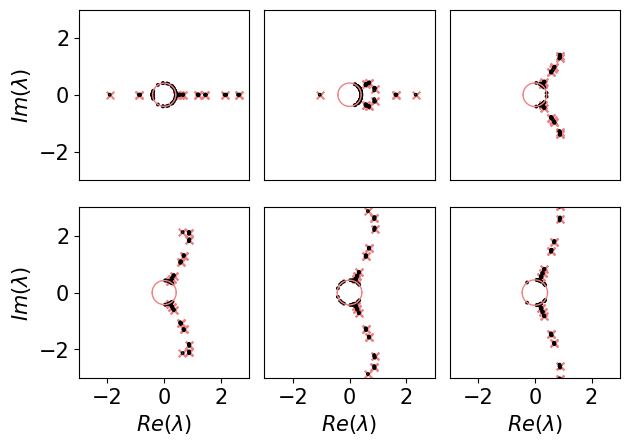

In [9]:
xlim, ylim = (-3,3), (-3,3)
repeat_num = 10
num = 2

fig, axes = plt.subplots(2, 3)

for param_n, ax in enumerate(axes.flat):
    eigs = np.load(generate_filename(num, param_n))
        
    changed_param = changed_param_exp_list[param_n]
    params = generate_params(changed_param)

    radius = calc_pred_radius(params,dim=2)
    x_dots = np.linspace(-radius, radius, 200)
    y_dots = np.sqrt(radius**2 - x_dots**2)
    
    ax.plot(x_dots, y_dots, c='lightcoral', linewidth=1)
    ax.plot(x_dots, -y_dots, c='lightcoral', linewidth=1)

    lambda_list_pred_select, label_list_pred_select= calc_pred_outliers(params, dim=2)
    real_part_pred_select, imag_part_pred_select = np.real(np.array(lambda_list_pred_select)), np.imag(np.array(lambda_list_pred_select))
    ax.scatter(real_part_pred_select, imag_part_pred_select, s=30, c='lightcoral', marker='x')
    real_part = np.real(eigs)
    imag_part = np.imag(eigs)
    ax.scatter(real_part, imag_part, s=3, c='none', marker='o', edgecolors='k')
    #ax.set_xlim([-1.5, 2.5])  # 根据具体需要调整范围
    #ax.set_ylim([-2, 2])  # 根据具体需要调整范围
    
    if param_n // 3 == 1:  # 最下面一行，添加x轴标签和刻度
        ax.set_xlabel("$Re(\\lambda)$", fontsize=15)
        #ax.set_xticks([-1, 0, 1, 2])  # 设置x轴刻度位置
        ax.tick_params(axis='x', labelsize=15)  # 控制x轴刻度的字体大小
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3)) 
    else:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # 隐藏x轴刻度和标签
    
    if param_n % 3 == 0:  # 最左边一列，添加y轴标签和刻度
        ax.set_ylabel("$Im(\\lambda)$", fontsize=15)
        #ax.set_yticks([-2, 0, 2])  # 设置y轴刻度位置
        ax.tick_params(axis='y', labelsize=15)  # 控制y轴刻度的字体大小
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3)) 
    else:
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)  # 隐藏y轴刻度和标签
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal') 

plt.tight_layout()
plt.savefig(r'../../figs/'+fig_filename+'_eigenspectrum.jpg', bbox_inches='tight')
plt.show()

以下除掉outliers的办法只是权宜之计，更好的办法是根据eig_V的空间分布去除掉outliers

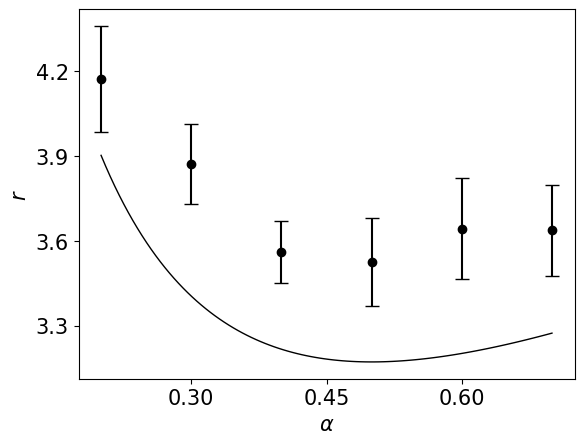

In [12]:
repeat_num, detect_k_num = 10, 20
#以下是理论预测
R_pred_line = []
for param_n in range(len(changed_param_plot_list)):
    changed_param = changed_param_plot_list[param_n]
    params = generate_params(changed_param)
    radius = calc_pred_radius(params, dim=2)
    R_pred_line.append(radius)
plt.plot(np.array(changed_param_plot_list), R_pred_line,c='k',linewidth=1)
#以下是实际实验结果
R_exp_line, R_exp_sigma = [], []
for param_n in range(len(changed_param_exp_list)):
    R_list_one_par = []
    for num in range(repeat_num):
        changed_param = changed_param_exp_list[param_n]
        params = generate_params(changed_param)
        lambda_list_pred_select,label_list_pred_select = calc_pred_outliers(params,dim=2)
        
        eigs = np.load(generate_filename(num,param_n))
        eigs_select = eigs.copy()  
        eigs_select = get_eigs_diskpart(eigs_select, lambda_list_pred_select, label_list_pred_select)
        R_list_one_par.append(np.max(np.abs(eigs_select)))
    R_exp_line.append(np.mean(np.array(R_list_one_par)))
    R_exp_sigma.append(np.std(np.array(R_list_one_par)))

plt.errorbar(np.array(changed_param_exp_list), R_exp_line, yerr=R_exp_sigma, fmt='ko', capsize=5)        

# plt.xticks([0.2,0.4,0.6])
# plt.yticks([0.8,0.9,1.0,1.1])
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
plt.xlabel(xlabel,fontsize=15)
plt.ylabel("$r$",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(r'../../figs/'+fig_filename+'_radius.jpg', bbox_inches='tight')

C:\Users\huang-yh20\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\huang-yh20\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\huang-yh20\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\huang-yh20\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\huang-yh20\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\huang-yh20\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarr

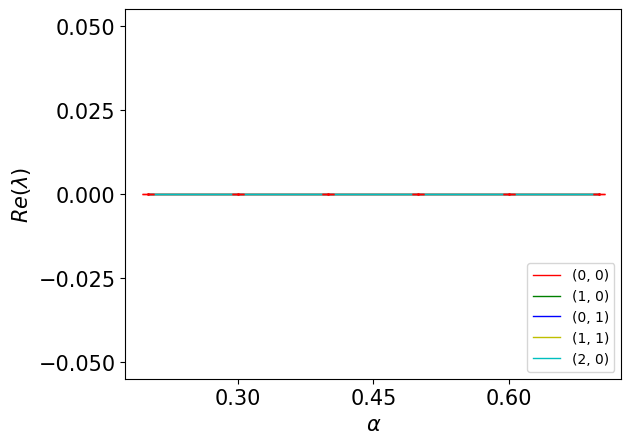

In [15]:
label_plot_list = [(1,0,0),(1,1,0),(1,0,1),(1,1,1),(1,2,0)]
c_list = ['r','g','b','y','c','m']

plot_line = 'imag'
for label_n in range(len(label_plot_list)): 
    label = label_plot_list[label_n]
    real_part_pred_line, imag_part_pred_line = [], []
    for param_n in range(len(changed_param_plot_list)):
        changed_param = changed_param_plot_list[param_n]
        params = generate_params(changed_param)
        lambda_list_pred_select,label_list_pred_select = calc_pred_outliers(params,dim=2)
        try:
            lambda_pred = lambda_list_pred_select[label_list_pred_select.index(label)]
        except ValueError:
            lambda_pred = np.nan
        real_part_pred_line.append(np.real(lambda_pred))
        imag_part_pred_line.append(np.imag(lambda_pred))
    if plot_line == 'real':
        plt.plot(changed_param_plot_list, real_part_pred_line,c=c_list[label_n],linewidth=1)
    else:
        plt.plot(changed_param_plot_list, imag_part_pred_line,c=c_list[label_n],linewidth=1)

for label_n in range(len(label_plot_list)):
    label = label_plot_list[label_n]
    real_part_exp_mean, real_part_exp_std = [], []
    imag_part_exp_mean, imag_part_exp_std = [], []
    for param_n in range(len(changed_param_exp_list)):
        changed_param = changed_param_exp_list[param_n]
        params = generate_params(changed_param)
        lambda_list_pred_select,label_list_pred_select = calc_pred_outliers(params,dim=2)

        finded_points_list = []
        for trail in range(repeat_num):
            eigs = np.load(generate_filename(trail, param_n))
            try:
                pred_label_index = label_list_pred_select.index(label)
                added_points_index = find_points(eigs, lambda_list_pred_select[pred_label_index], degenerate_num(label))
                finded_points_list += [eigs[index] for index in added_points_index]
            except ValueError:
                pass
        real_part_exp_mean.append(np.mean(np.real(np.array(finded_points_list))))
        imag_part_exp_mean.append(np.mean(np.imag(np.array(finded_points_list))))
        real_part_exp_std.append(np.std(np.real(np.array(finded_points_list))))
        imag_part_exp_std.append(np.std(np.imag(np.array(finded_points_list))))
    if plot_line == 'real':
        plt.errorbar(changed_param_exp_list, real_part_exp_mean, yerr=real_part_exp_std, fmt=c_list[label_n]+'o',markersize=1, capsize=4)
        plt.ylabel("$Re(\\lambda)$",fontsize=15)
    else: 
        plt.errorbar(changed_param_exp_list, imag_part_exp_mean, yerr=imag_part_exp_std, fmt=c_list[label_n]+'o',markersize=1, capsize=4)
        plt.ylabel("$Im(\\lambda)$",fontsize=15)
plt.legend(loc="lower right", labels=[label[1::] for label in label_plot_list])
# plt.xticks([0.05,0.10,0.15])
# plt.yticks([0.4,0.6,0.8,1.0,1.2])
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
plt.xlabel(xlabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
if plot_line == 'real':
    plt.savefig(r'../../figs/'+fig_filename+'_real_outliers.jpg', bbox_inches='tight')
else:
    plt.savefig(r'../../figs/'+fig_filename+'_imag_outliers.jpg', bbox_inches='tight')